
# Deconvolving images with the instrument Point Spread Function (PSF)

This example demonstrates how to deconvolve an AIA image with
the instrument point spread function (PSF).


In [1]:
try:
    import cupy
except:
    %pip install cupy

  Using cached cupy-13.3.0.tar.gz (3.4 MB)
  Preparing metadata (setup.py) ... done
  Using cached fastrlock-0.8.2-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl (52 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [100 lines of output]
      Generating cache key from header files...
      Cache key (1610 files matching /tmp/pip-install-3774anrc/cupy_73cc3ca195854437bb7c1fbb6ff66bc3/cupy/_core/include/**): a551dc2c7dbb00917f27c8f63e32b3fb479e71da
      Clearing directory: /tmp/pip-install-3774anrc/cupy_73cc3ca195854437bb7c1fbb6ff66bc3/cupy/.data
      
      -------- Configuring Module: cuda --------
      
      -------- Configuring Module: cusolver --------
      
      -------- Configuring Module: cudnn --------
      
      -------- Configuring Module: nccl --------
      
      -------- Configuring Module: nvtx --------
      
      -------- Configuring Module: cutensor -------

In [4]:
import time

import astropy.units as u
import matplotlib.pyplot as plt
import sunpy.map
from astropy.coordinates import SkyCoord
from astropy.visualization import AsinhStretch, ImageNormalize, LogStretch

import aiapy.data.sample as sample_data
import aiapy.psf

AIA images are subject to convolution with the instrument point-spread
function (PSF) due to effects introduced by the filter mesh of the telescope
and the CCD, among others. This has the effect of "blurring" the image.
The PSF diffraction pattern may also be particularly noticeable during the
impulsive phase of a flare where the intensity enhancement is very localized.
To remove these artifacts, the PSF must be de-convolved from the image.

First, we'll use a single level 1 image from the 171 Å channel from
15 March 2019. Note that deconvolution should be performed on level 1 images
only. This is because, as with the level 1 data, the PSF model is defined
on the CCD grid. Once deconvolved, the image can be passed to
`aiapy.calibrate.register`
(see the `sphx_glr_generated_gallery_prepping_level_1_data.py` example).



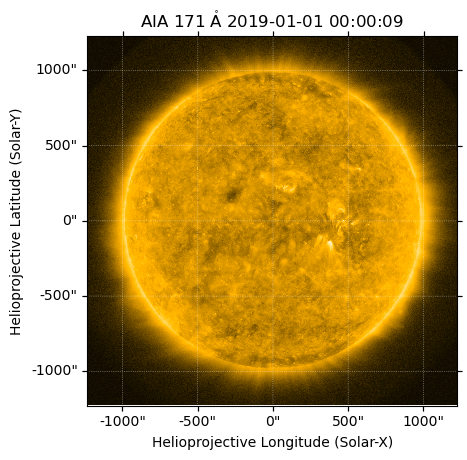

In [2]:
aia_map = sunpy.map.Map(sample_data.AIA_171_IMAGE)

fig = plt.figure()
ax = fig.add_subplot(111, projection=aia_map)
aia_map.plot(
    axes=ax,
)

Next, we'll calculate the PSF using `aiapy.psf.psf` for the 171 Å channel.
The PSF model accounts for several different effects, including diffraction
from the mesh grating of the filters, charge spreading, and jitter. See
[Grigis et al (2012)](https://sohoftp.nascom.nasa.gov/solarsoft/sdo/aia/idl/psf/DOC/psfreport.pdf)
for more details. Currently, this only works for  $4096\times4096$ full frame images.

Note that this will be significantly faster if you have a Nvidia GPU and the `cupy`
package installed.



In [3]:
now=time.time()
psf = aiapy.psf.psf(aia_map.wavelength)
print(f"Took {time.time()-now}")

We'll plot just a 500-by-500 pixel section centered on the center pixel. The
diffraction "arms" extending from the center pixel can often be seen in
flare observations due to the intense, small-scale brightening.



Text(0, 0.5, 'Pixels')

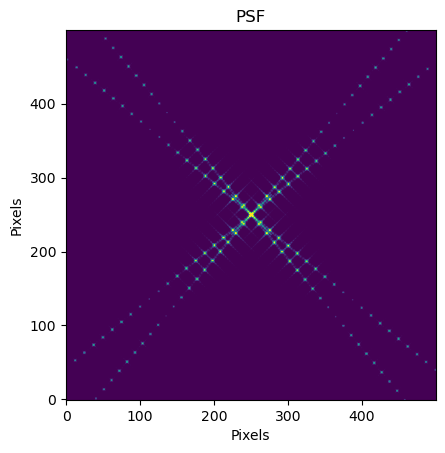

In [5]:
fov = 500
lc_x, lc_y = psf.shape[0] // 2 - fov // 2, psf.shape[1] // 2 - fov // 2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(
    psf[lc_x : lc_x + fov, lc_y : lc_y + fov],
    norm=ImageNormalize(vmin=1e-8, vmax=1e-3, stretch=LogStretch()),
    origin="lower",
)
ax.set_title("PSF")
ax.set_xlabel("Pixels")
ax.set_ylabel("Pixels")

Now that we've downloaded our image and computed the PSF, we can deconvolve
the image with the PSF using the
[Richardson-Lucy deconvolution algorithm](https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution).
Note that passing in the PSF is optional. If you exclude it, it will be
calculated automatically. However, when deconvolving many images of the same
wavelength, it is most efficient to only calculate the PSF once.

As with `aiapy.psf.psf`, this will be much faster if you have
a Nvidia GPU and `cupy` installed.



In [6]:
now=time.time()
aia_map_deconvolved = aiapy.psf.deconvolve(aia_map, psf=psf)
print(f"Took {time.time()-now}")

Took 39.9810950756073


Let's compare the convolved and deconvolved images.



In [ ]:
fig = plt.figure()
ax = fig.add_subplot(121, projection=aia_map)
norm = ImageNormalize(vmin=0, vmax=1.5e4, stretch=AsinhStretch(0.01))
aia_map.plot(axes=ax, norm=norm)
ax.set_title("Normal")

ax = fig.add_subplot(122, projection=aia_map_deconvolved)
aia_map_deconvolved.plot(axes=ax, annotate=False, norm=norm)
ax.set_title("Deconvolved")
ax.coords[0].set_axislabel(" ")
ax.coords[1].set_axislabel(" ")
ax.coords[1].set_ticklabel_visible(visible=False)
fig.tight_layout()

The differences become a bit more obvious when we zoom in. Note that the
deconvolution has the effect of "deblurring" the image.



In [ ]:
left_corner = 500 * u.arcsec, -600 * u.arcsec
right_corner = 1000 * u.arcsec, -100 * u.arcsec

aia_map_sub = aia_map.submap(
    bottom_left=SkyCoord(*left_corner, frame=aia_map.coordinate_frame),
    top_right=SkyCoord(*right_corner, frame=aia_map.coordinate_frame),
)
aia_map_deconvolved_sub = aia_map_deconvolved.submap(
    bottom_left=SkyCoord(*left_corner, frame=aia_map_deconvolved.coordinate_frame),
    top_right=SkyCoord(*right_corner, frame=aia_map_deconvolved.coordinate_frame),
)

fig = plt.figure()

ax = fig.add_subplot(121, projection=aia_map_sub)
aia_map_sub.plot(axes=ax, norm=norm)
ax.set_title("Normal")

ax = fig.add_subplot(122, projection=aia_map_deconvolved_sub)
aia_map_deconvolved_sub.plot(axes=ax, annotate=False, norm=norm)
ax.set_title("Deconvolved")
ax.coords[0].set_axislabel(" ")
ax.coords[1].set_axislabel(" ")
ax.coords[1].set_ticklabel_visible(visible=False)

plt.show()